<a href="https://colab.research.google.com/github/Zshoham/YHB/blob/main/assignment2/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [1]:
import requests
import zipfile
import os

if not os.path.isdir('PAMAP2_Dataset'):
  req = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip")
  with open("PAMAP2_Dataset.zip", 'wb') as f:
    f.write(req.content) 
    
  with zipfile.ZipFile("PAMAP2_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()


column_names = ["time", "activity_id", "heart_rate"]
column_names += ["IMU_hand" + str(i) for i in range(17)]
column_names +=["IMU_chest" + str(i) for i in range(17)]
column_names +=["IMU_ankle" + str(i) for i in range(17)]

activity_map = {1: "lying", 2: "sitting", 3: "standing", 4: "walking",
                5: "running", 6: "cycling", 7: "Nordic walking", 9: "watching TV",
                10: "computer work", 11: "car driving", 12: "ascending stairs",
                13: "descending stairs", 16: "vacum cleaning", 17: "ironing", 
                18: "folding laundry", 19: "house cleaning", 20: "playing soccer",
                24: "rope jumping", 0: "other"}

# Data Exploration - 1.a + 1.b

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='darkgrid')

def load_subject(number_str):
  subj = pd.read_csv("PAMAP2_Dataset/Protocol/subject" + number_str + ".dat", names=column_names, delim_whitespace=True) 
  # we add the activity names
  subj["activity_name"] = subj["activity_id"].map(lambda id: activity_map[id])

  # we remove all the IMU readings that are not relevant.
  for i in range(13, 17):
    subj = subj.drop(["IMU_hand" + str(i), "IMU_chest" + str(i), "IMU_ankle" + str(i)], axis=1)
  
  return subj

subj101 = load_subject("101")

In [ ]:
subj101.describe()

,time,activity_id,heart_rate,IMU_hand0,IMU_hand1,IMU_hand2,IMU_hand3,IMU_hand4,IMU_hand5,IMU_hand6,IMU_hand7,IMU_hand8,IMU_hand9,IMU_hand10,IMU_hand11,IMU_hand12,IMU_chest0,IMU_chest1,IMU_chest2,IMU_chest3,IMU_chest4,IMU_chest5,IMU_chest6,IMU_chest7,IMU_chest8,IMU_chest9,IMU_chest10,IMU_chest11,IMU_chest12,IMU_ankle0,IMU_ankle1,IMU_ankle2,IMU_ankle3,IMU_ankle4,IMU_ankle5,IMU_ankle6,IMU_ankle7,IMU_ankle8,IMU_ankle9,IMU_ankle10,IMU_ankle11,IMU_ankle12
count,376417.000000,376417.000000,34389.000000,374963.000000,374963.000000,374963.000000,374963.000000,374963.000000,374963.000000,374963.000000,374963.000000,374963.000000,374963.000000,374963.000000,374963.000000,374963.000000,375908.000000,375908.000000,375908.000000,375908.000000,375908.000000,375908.000000,375908.000000,375908.000000,375908.000000,375908.000000,375908.000000,375908.000000,375908.000000,375090.000000,375090.000000,375090.000000,375090.000000,375090.000000,375090.000000,375090.000000,375090.000000,375090.000000,375090.000000,375090.000000,375090.000000,375090.000000
mean,1890.460000,5.525765,124.135479,32.429895,-3.349118,6.278528,3.407735,-3.290532,6.303530,3.572275,0.032741,0.046213,0.002308,15.241566,-30.967448,-24.865800,35.343487,0.293268,8.364075,-2.472689,0.139136,8.374918,-2.189943,0.003033,-0.001641,-0.018712,-0.202675,-46.396562,9.019082,33.793903,9.413902,0.345152,-2.194919,9.385298,0.461362,-1.769552,-0.000110,0.000361,0.013872,-50.873072,-4.103087,10.433775
std,1086.623725,6.617002,24.000340,1.236379,6.365465,5.196436,3.383241,6.395511,5.217042,3.369418,1.072581,0.870798,1.654828,34.810636,28.419473,28.371311,1.394300,1.782331,4.880720,4.078004,1.771189,4.846426,4.063583,0.469694,0.560575,0.307229,23.959689,21.400891,29.523340,0.969374,5.868752,7.443008,3.720882,5.532037,6.652477,3.421688,0.996037,0.603546,1.786058,25.724727,30.615311,29.524187
min,8.380000,0.000000,78.000000,30.000000,-127.649000,-81.234400,-34.124800,-56.984200,-42.797200,-22.052200,-11.259100,-22.212700,-10.608800,-75.282900,-174.246000,-497.632000,31.812500,-19.939900,-25.955900,-53.401900,-17.606700,-25.289400,-48.660900,-4.891900,-4.672250,-2.642760,-76.245200,-122.480000,-66.684700,30.312500,-49.507200,-155.356000,-133.640000,-46.950900,-61.898600,-48.253400,-11.688700,-7.807450,-11.619400,-172.865000,-137.908000,-109.289000
25%,949.420000,0.000000,104.000000,31.437500,-7.840210,3.591230,1.502020,-7.718755,3.635865,1.693380,-0.344787,-0.218379,-0.340881,-13.010950,-49.732600,-47.036900,34.000000,-0.474172,6.484972,-4.028037,-0.582286,6.458317,-3.760047,-0.097836,-0.122735,-0.115753,-18.560550,-59.913250,-9.165997,33.187500,8.893663,-2.067800,-3.354192,8.870140,-1.980000,-2.931093,-0.190940,-0.047853,-0.308403,-63.485375,-28.488200,-9.834780
50%,1890.460000,3.000000,125.000000,32.812500,-2.982460,6.009140,3.464280,-2.923560,6.049510,3.674220,-0.001522,0.008506,-0.005281,16.003700,-34.203100,-25.367400,35.437500,0.279356,9.421840,-2.014510,0.131119,9.414445,-1.698640,-0.000102,-0.004316,-0.015394,-0.884211,-53.553850,11.749550,34.000000,9.624330,-0.177941,-1.733430,9.629720,-0.105864,-1.284310,-0.001233,0.003658,-0.002747,-53.249850,-5.071440,11.097900
75%,2831.500000,7.000000,136.000000,33.500000,1.669090,8.621120,5.551850,1.769210,8.605695,5.726600,0.340210,0.287393,0.339454,44.122700,-15.220550,-4.448135,36.750000,0.944058,9.761010,-1.307097,0.782600,9.771080,-0.991846,0.088409,0.136399,0.068062,15.995900,-38.922975,29.965025,34.687500,10.000600,1.997383,-0.523223,9.985893,2.146390,-0.074993,0.067853,0.168119,0.057149,-36.340800,20.731550,33.179775
max,3772.540000,24.000000,183.000000,33.875000,26.145800,106.898000,132.295000,19.110700,62.060600,53.617100,16.483800,8.666640,9.998620,172.590000,94.127400,164.708000,37.250000,17.929500,107.825000,16.747900,15.230800,61.911200,15.856600,10.353200,3.854010,1.891490,80.473900,43.061300,96.358500,35.000000,149.718000,155.960000,83.884500,61.969300,62.023800,44.231200,13.142500,6.410380,9.377020,97.525500,123.306000,124.806000


Our task is predicting the activity of a subject given a history of his sensor readings. As we can see above our data consists of time, activity_id - which we also convert to activity name later, heart rate, hand sensors, chest sensors, and ankle sensors. In this section we explore the data and try to suggest preprocessing methods. Most of the work in this section uses only one subject as an example though the methods will be applied to all the subject when training the models.

In [ ]:
subj101.head()

,time,activity_id,heart_rate,IMU_hand0,IMU_hand1,IMU_hand2,IMU_hand3,IMU_hand4,IMU_hand5,IMU_hand6,IMU_hand7,IMU_hand8,IMU_hand9,IMU_hand10,IMU_hand11,IMU_hand12,IMU_chest0,IMU_chest1,IMU_chest2,IMU_chest3,IMU_chest4,IMU_chest5,IMU_chest6,IMU_chest7,IMU_chest8,IMU_chest9,IMU_chest10,IMU_chest11,IMU_chest12,IMU_ankle0,IMU_ankle1,IMU_ankle2,IMU_ankle3,IMU_ankle4,IMU_ankle5,IMU_ankle6,IMU_ankle7,IMU_ankle8,IMU_ankle9,IMU_ankle10,IMU_ankle11,IMU_ankle12,activity_name
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,-0.092217,0.056812,-0.015845,14.6806,-69.2128,-5.58905,31.8125,0.238080,9.80003,-1.68896,0.265304,9.81549,-1.41344,-0.005065,-0.006781,-0.005663,0.471960,-51.0499,43.2903,30.3125,9.65918,-1.65569,-0.099797,9.64689,-1.55576,0.310404,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,other
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,-0.024413,0.047758,0.006474,14.8991,-69.2224,-5.82311,31.8125,0.319530,9.61282,-1.49328,0.234939,9.78539,-1.42846,0.013685,0.001486,-0.041522,1.016900,-50.3966,43.1768,30.3125,9.69370,-1.57902,-0.215687,9.61670,-1.61630,0.280488,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,other
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,-0.057976,0.032574,-0.006988,14.2420,-69.5197,-5.12442,31.8125,0.235593,9.72421,-1.76621,0.173850,9.72528,-1.51894,-0.039923,0.034056,-0.002113,0.383136,-51.8336,43.7782,30.3125,9.58944,-1.73276,0.092914,9.63173,-1.58605,0.280311,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,other
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,-0.002352,0.032810,-0.003747,14.8908,-69.5439,-6.17367,31.8125,0.388697,9.53572,-1.72410,0.157969,9.64994,-1.57952,0.007513,-0.010498,-0.020684,0.315400,-49.8144,43.1670,30.3125,9.58814,-1.77040,0.054545,9.63197,-1.63135,0.340997,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,other
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,0.012269,0.018305,-0.053325,15.5612,-68.8196,-6.28927,31.8125,0.315800,9.49908,-1.60914,0.233506,9.57411,-1.44418,-0.003822,-0.011217,-0.025975,-0.297733,-51.8097,43.6453,30.3125,9.69771,-1.65625,-0.060809,9.64699,-1.64647,0.340965,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,other


In [ ]:
print("number of records: ", len(subj101))
print("number of invalid activities: ", len(subj101[subj101.activity_id == 0]))
print("number of missing heart_rate messurments: ", subj101.heart_rate.isna().sum())
print("number of valid records: ", len(subj101[(subj101.activity_id != 0) & (subj101.heart_rate.notna())]))

number of records:  376417
number of invalid activities:  126460
number of missing heart_rate messurments:  342028
number of valid records:  22846


We can see that most of the heart rate messurments are missing, this is because the sensor messure the heart rate at a much lower frequency then the other inputs.

In order to fix this, we will need to fill in those missing values, lets take a look at the heart rate up close compared to the IMU_hand1 reading for example.

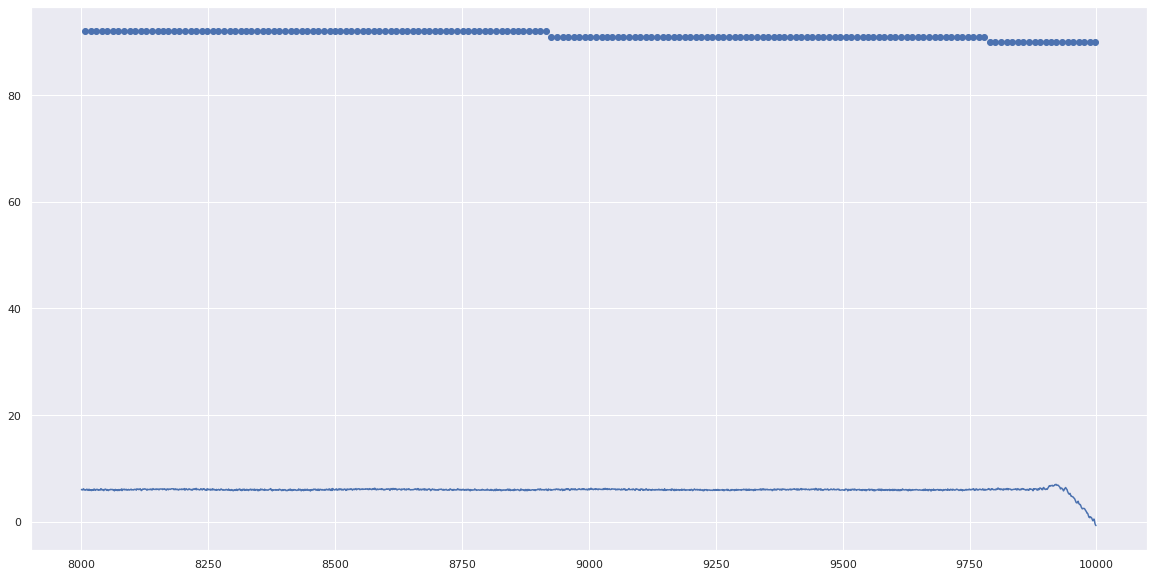

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(subj101.IMU_hand1[8000:10000])
plt.scatter(x= range(8000,10000), y=subj101.heart_rate[8000:10000])

 We can see that the IMU data is very smooth (sampled more continuesly) while the heart rate data is relativly discrete. Because the heart rate seems to fluctuate very little the best way to fill the missing data would be useing interpolation.

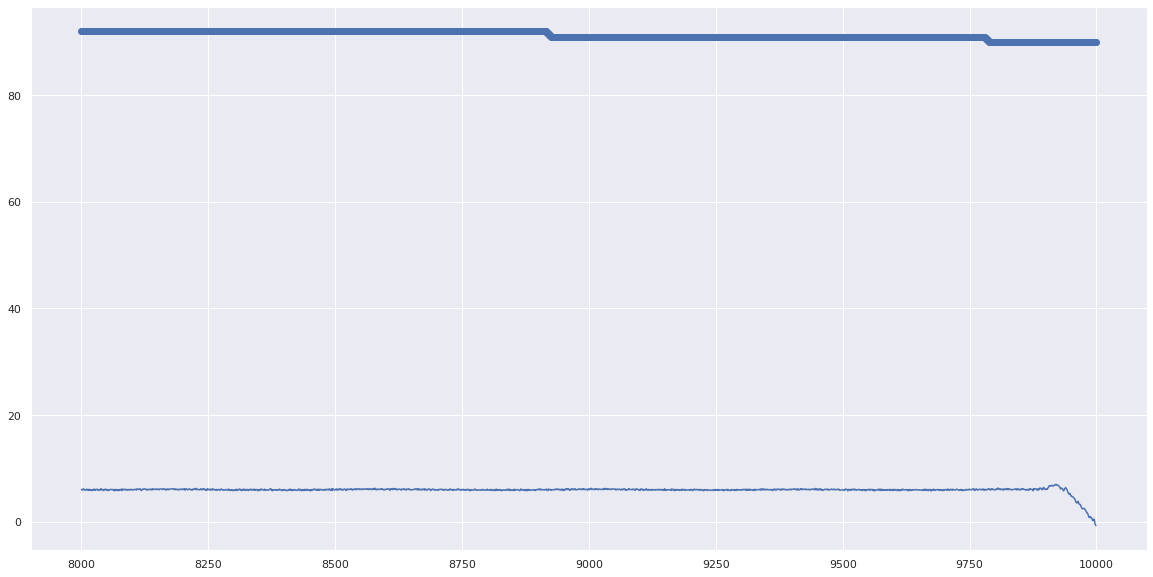

In [ ]:
subj101["smooth_heart_rate"] = subj101["heart_rate"].interpolate()
plt.figure(figsize = (20,10))
plt.plot(subj101.IMU_hand1[8000:10000])
plt.scatter(x= range(8000,10000), y=subj101.smooth_heart_rate[8000:10000])

We now have very smooth heart rate data that does not change the behavior of the original data.

We are now going to fill all the missing values for the sensors with the same method. The only remaining column with NaN values is the original heart rate, which we will use for more readable visualizations.

In [ ]:
subj101.iloc[:, 3:42] = subj101.iloc[:, 3:42].interpolate()
subj101.isna().sum()

time                      0
activity_id               0
heart_rate           342028
IMU_hand0                 0
IMU_hand1                 0
IMU_hand2                 0
IMU_hand3                 0
IMU_hand4                 0
IMU_hand5                 0
IMU_hand6                 0
IMU_hand7                 0
IMU_hand8                 0
IMU_hand9                 0
IMU_hand10                0
IMU_hand11                0
IMU_hand12                0
IMU_chest0                0
IMU_chest1                0
IMU_chest2                0
IMU_chest3                0
IMU_chest4                0
IMU_chest5                0
IMU_chest6                0
IMU_chest7                0
IMU_chest8                0
IMU_chest9                0
IMU_chest10               0
IMU_chest11               0
IMU_chest12               0
IMU_ankle0                0
IMU_ankle1                0
IMU_ankle2                0
IMU_ankle3                0
IMU_ankle4                0
IMU_ankle5                0
IMU_ankle6          

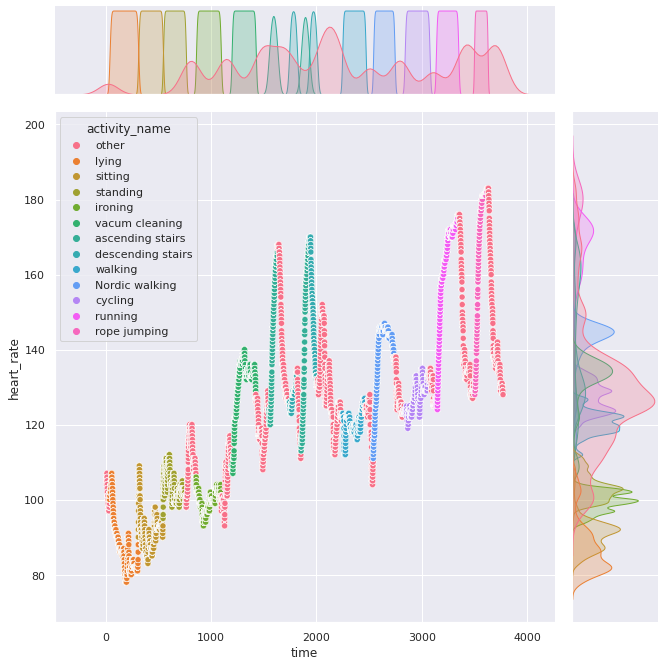

In [ ]:
p = sns.jointplot(data=subj101, x="time", y="heart_rate", hue="activity_name")
p.fig.set_figwidth(10)
p.fig.set_figheight(10)

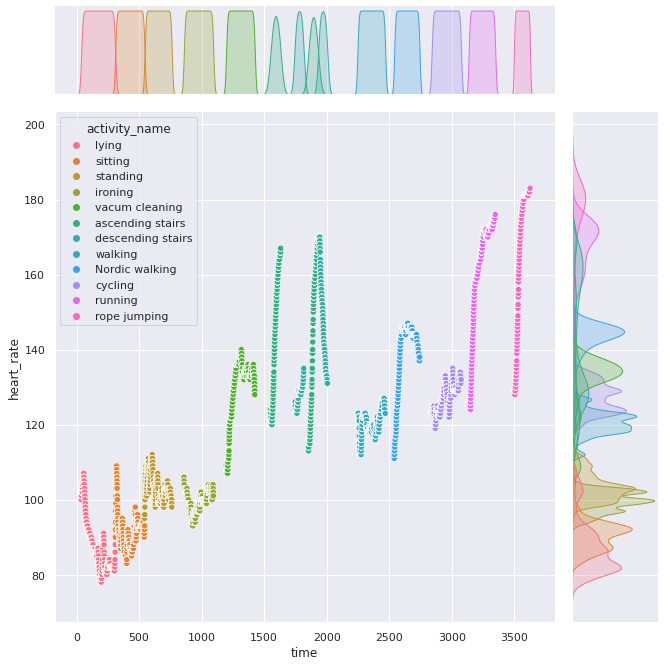

In [ ]:
def remove_invalid_ids(data):
  return data[data.activity_id != 0]

subj101 = remove_invalid_ids(subj101)

p = sns.jointplot(data=subj101, x="time", y="heart_rate", hue="activity_name")
p.fig.set_figwidth(10)
p.fig.set_figheight(10)

One interesting thing we found while exploring the data is subject 109 has only one valid activity, here we show some of the data of subject 109 and explain why we chose not to use him.

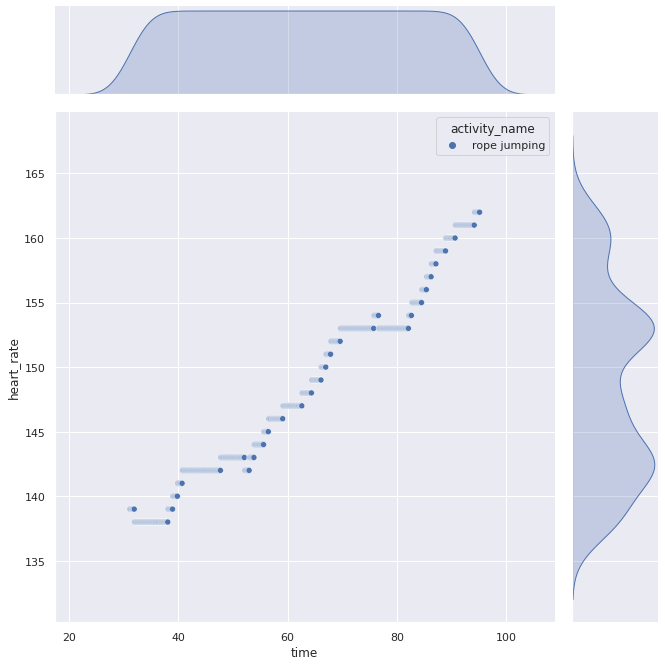

In [18]:
subj109 = load_subject("109")
subj109 = subj109[subj109.activity_id != 0]
p = sns.jointplot(data=subj109, x="time", y="heart_rate", hue="activity_name")
p.fig.set_figwidth(10)
p.fig.set_figheight(10)

In [20]:
subj109.activity_id.count()

6391

As we can see, this subject's data only contains 6391 time-steps with only one activity, where the heart rate is only rising with time. This is highly biased data, which we prefer not to use in our training because it could negatively affect the model.

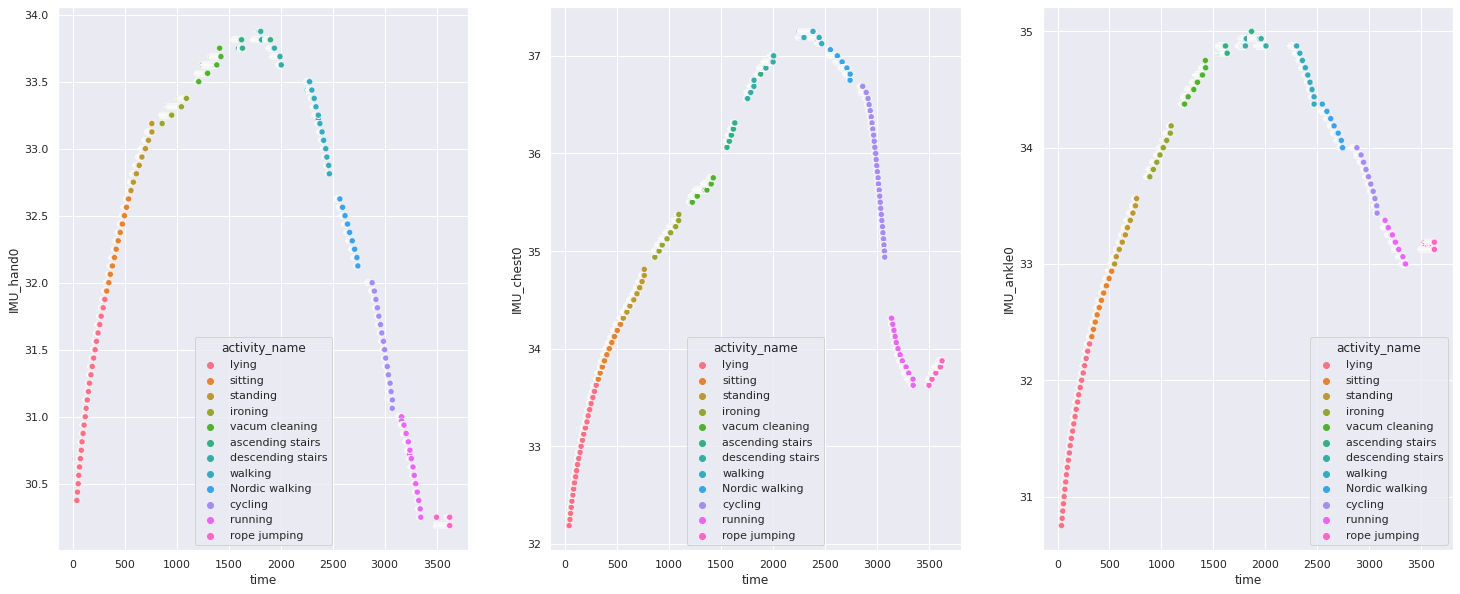

In [ ]:
subj101["heart_rate"] = subj101["smooth_heart_rate"]
subj101 = subj101.drop(columns=["smooth_heart_rate"])

fig, sub = plt.subplots(1,3, figsize=(25,10))

sns.scatterplot(ax=sub[0], data=subj101, x="time", y="IMU_hand0", hue="activity_name")
sns.scatterplot(ax=sub[1], data=subj101, x="time", y="IMU_chest0", hue="activity_name")
sns.scatterplot(ax=sub[2], data=subj101, x="time", y="IMU_ankle0", hue="activity_name")

From the graphs above it seems that the temperature readings simply go up during the day and then back down again. It does seem that the chest and ankle temperaturs do not return to as low a value as the hand. Comparing against different subjects is required but at first glance it seems that this information is irelevent to the activity being performed.

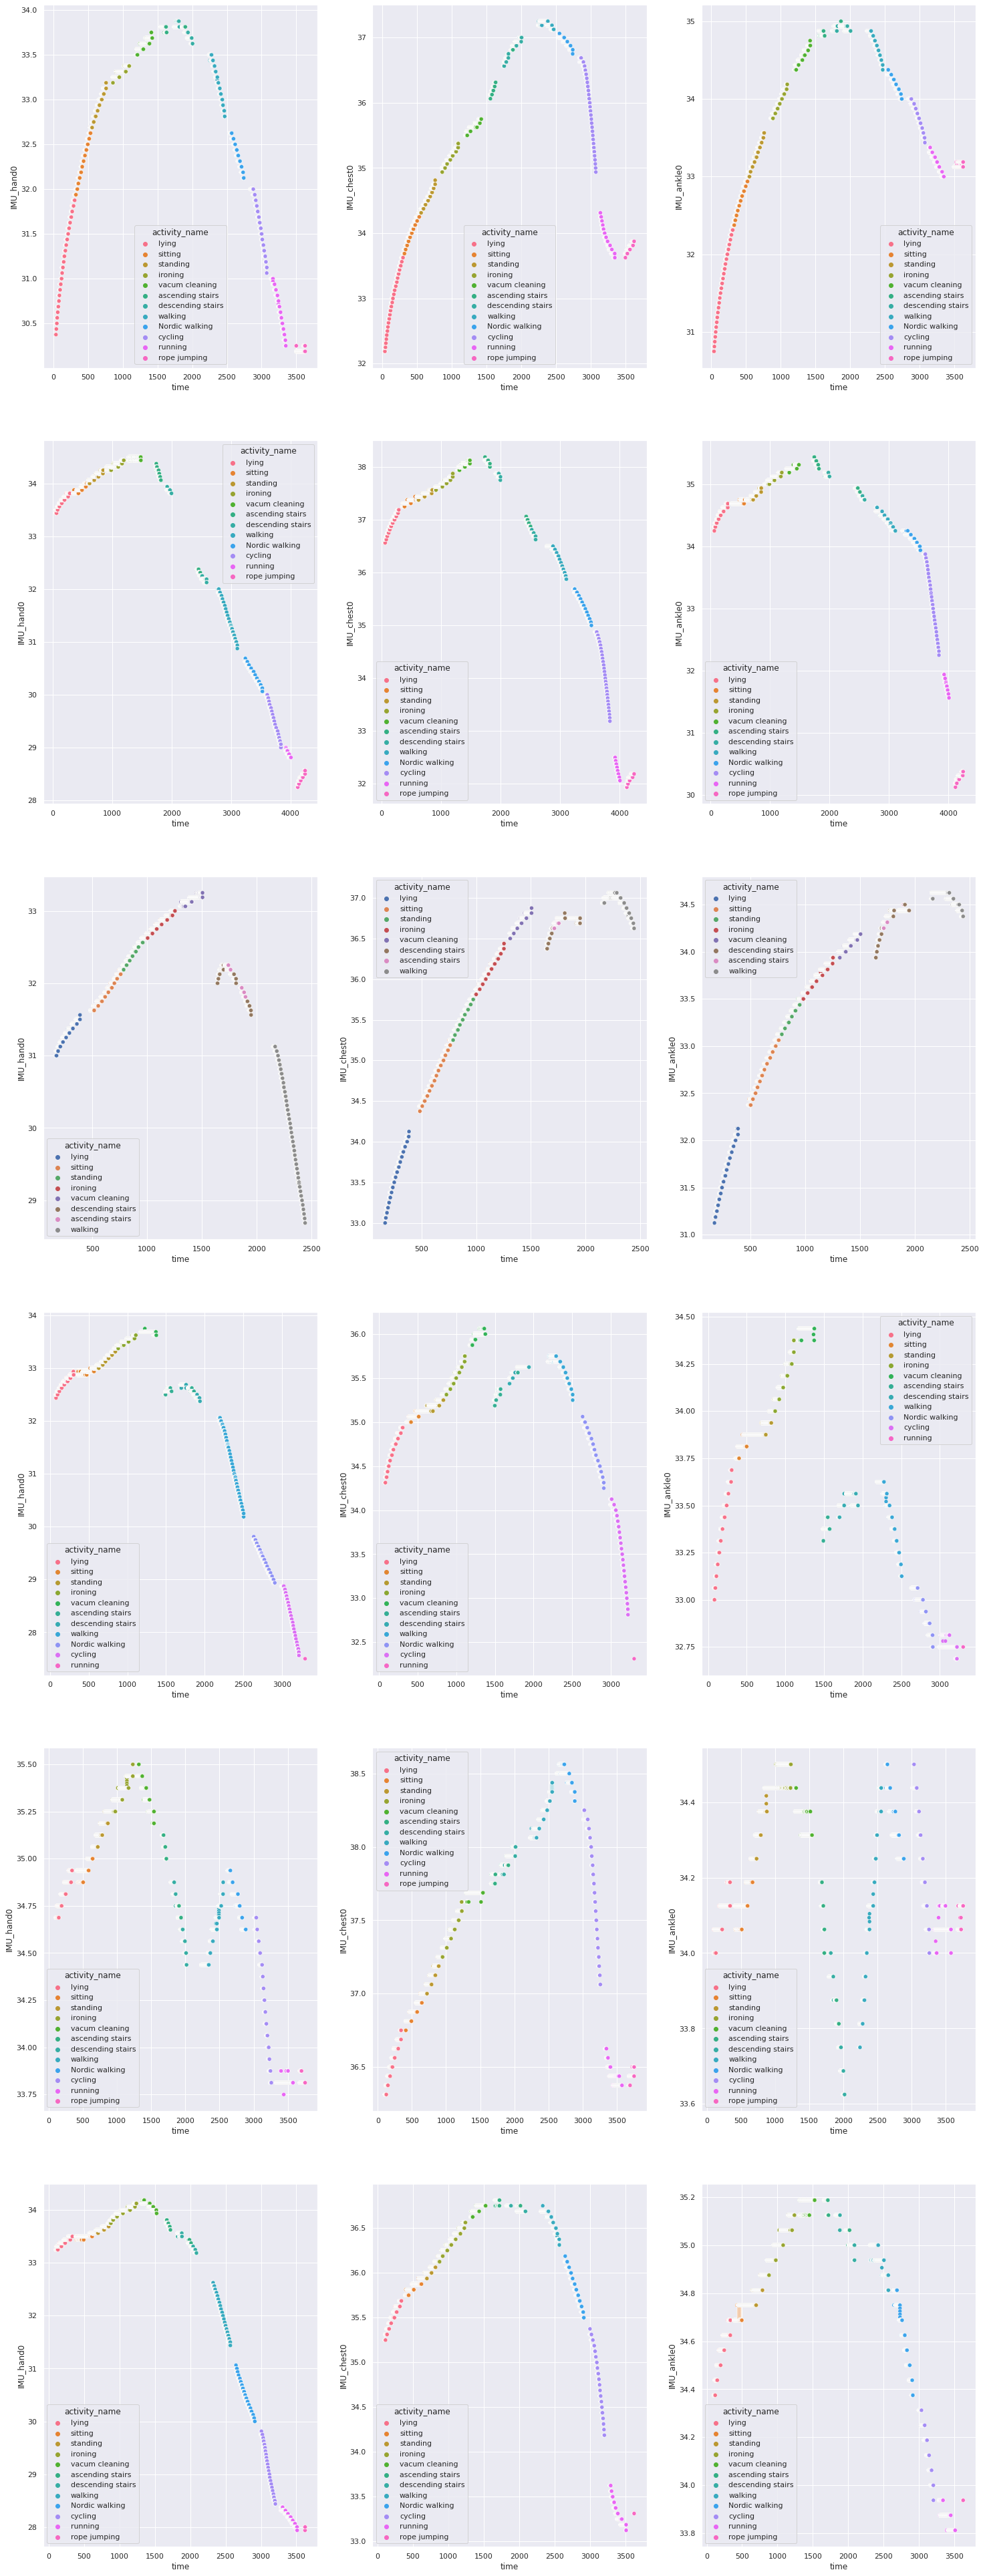

In [ ]:
def interpolate_sensors(data):
  data.iloc[:, 2:42] = data.iloc[:, 2:42].interpolate()

subjects = [subj101]

for i in range(2,7):
  subj = load_subject("10" + str(i))
  subj = remove_invalid_ids(subj)
  interpolate_sensors(subj)
  subjects.append(subj)


fig, sub = plt.subplots(6,3, figsize=(25,70))
for i in range(6):
  sns.scatterplot(ax=sub[i, 0], data=subjects[i], x="time", y="IMU_hand0", hue="activity_name")
  sns.scatterplot(ax=sub[i, 1], data=subjects[i], x="time", y="IMU_chest0", hue="activity_name")
  sns.scatterplot(ax=sub[i, 2], data=subjects[i], x="time", y="IMU_ankle0", hue="activity_name")

It does seem that most plots have some similar structure to the one described aboce, but it seems that they are too varied to dismiss these readings outright.
Lets also look at the correlation of these variables and see if an interesting pattern emerges.

                 time  activity_id  ...  IMU_chest0  IMU_ankle0
time         1.000000     0.290460  ...    0.399035    0.405889
activity_id  0.290460     1.000000  ...    0.197376    0.470291
heart_rate   0.820458     0.423818  ...    0.292616    0.419806
IMU_hand0   -0.340434     0.211061  ...    0.642453    0.717698
IMU_chest0   0.399035     0.197376  ...    1.000000    0.901427
IMU_ankle0   0.405889     0.470291  ...    0.901427    1.000000

[6 rows x 6 columns]


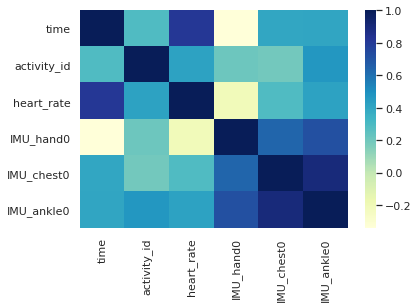

In [ ]:
temperture_corr = subj101[["time", "activity_id", "heart_rate", "IMU_hand0", "IMU_chest0", "IMU_ankle0"]].corr()
sns.heatmap(temperture_corr, cmap="YlGnBu")
print(temperture_corr)

From the correlation heatmap above we can see that the temperture readings are not correlated strongly with time, and are not strongly enogh correlated between themselves to consider dropping.

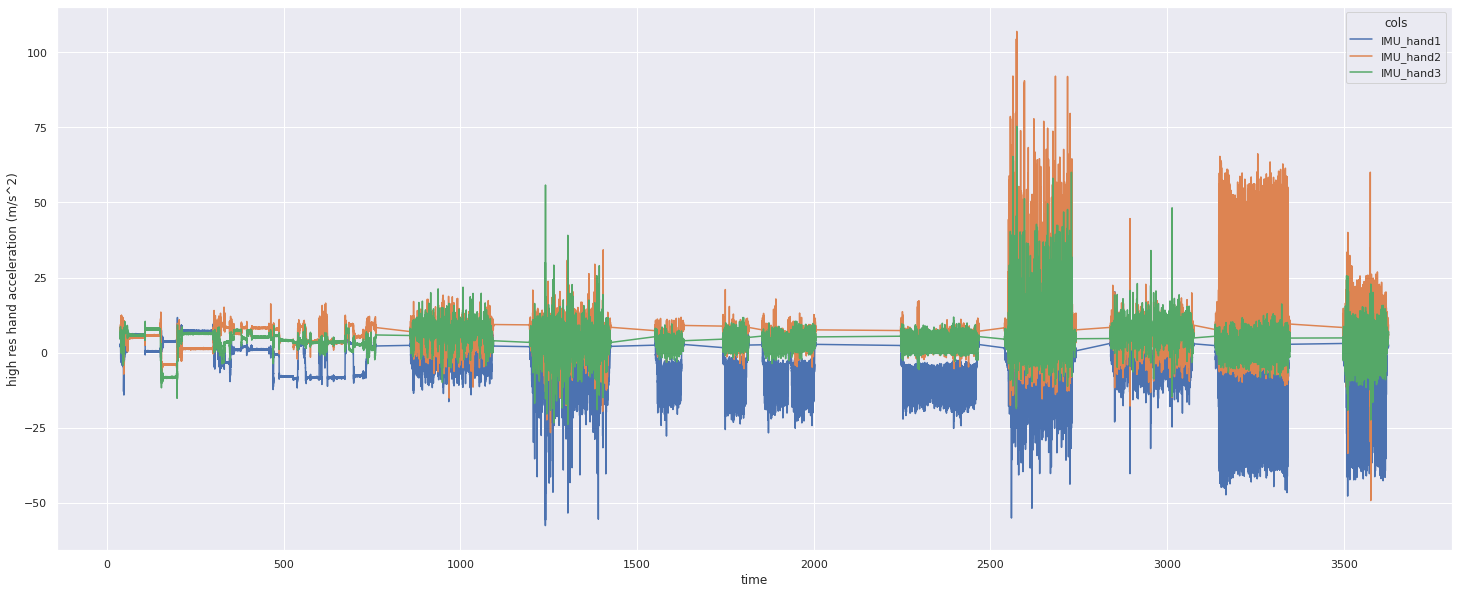

In [ ]:
fig = plt.gcf()
fig.set_size_inches(25, 10)

hr_hand_acc = subj101.melt(id_vars="time", value_vars=["IMU_hand1", "IMU_hand2", "IMU_hand3"] ,var_name="cols", value_name="high res hand acceleration (m/s^2)")
p = sns.lineplot(data=hr_hand_acc, x="time", y="high res hand acceleration (m/s^2)", hue="cols")

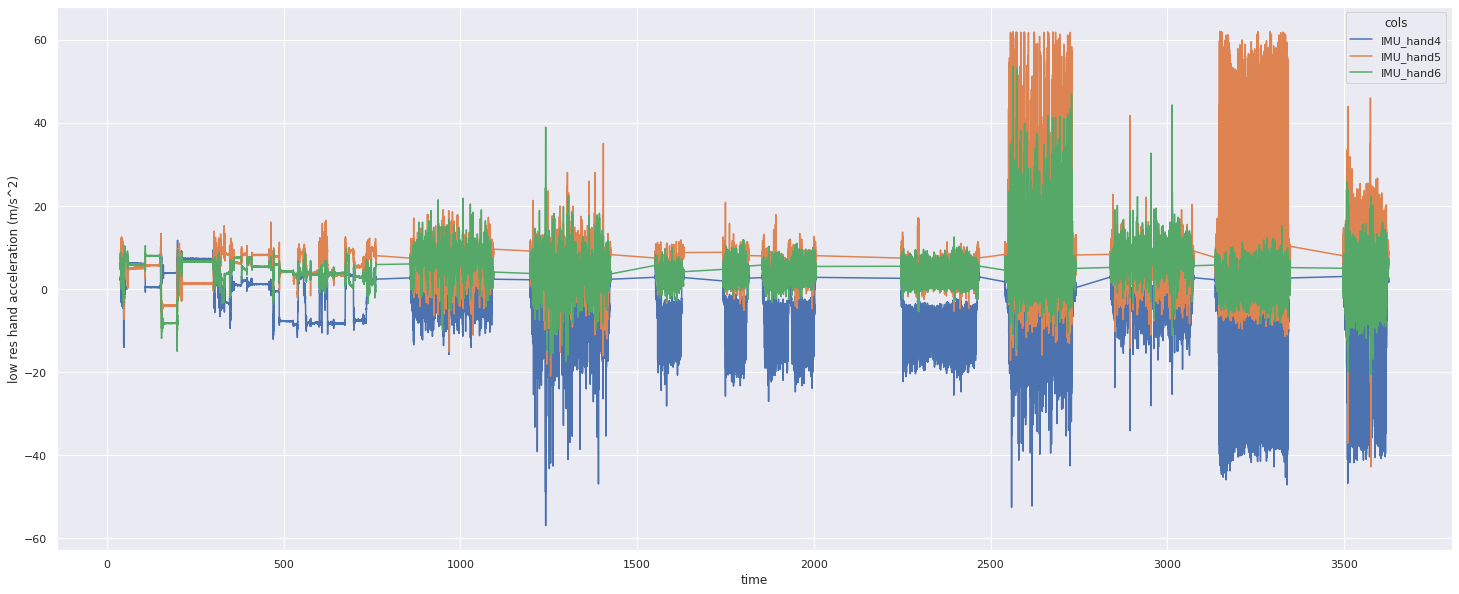

In [ ]:
fig = plt.gcf()
fig.set_size_inches(25, 10)

lr_hand_acc = subj101.melt(id_vars="time", value_vars=["IMU_hand4", "IMU_hand5", "IMU_hand6"] ,var_name="cols", value_name="low res hand acceleration (m/s^2)")
p = sns.lineplot(data=lr_hand_acc, x="time", y="low res hand acceleration (m/s^2)", hue="cols")

We can see that the high and low resultion acceleration plots look almost identical, apart from there being more noise in the high resulotion plot. Lets take a look at the correlations between these sensors and the activity and heart rate.

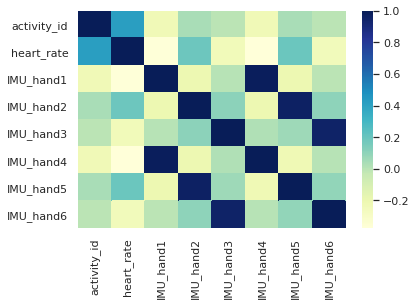

In [ ]:
acc_corr = subj101[["activity_id", "heart_rate", "IMU_hand1", "IMU_hand2", "IMU_hand3", "IMU_hand4", "IMU_hand5", "IMU_hand6"]].corr()

sns.heatmap(acc_corr, cmap="YlGnBu")

We can see that the correlation between the high resolution sensors and thier low resolution counter parts is 1 or very very close to 1. This means that we dont need to keep both as they represent the exact same information. We chosse to keep only the high resolution messurements.

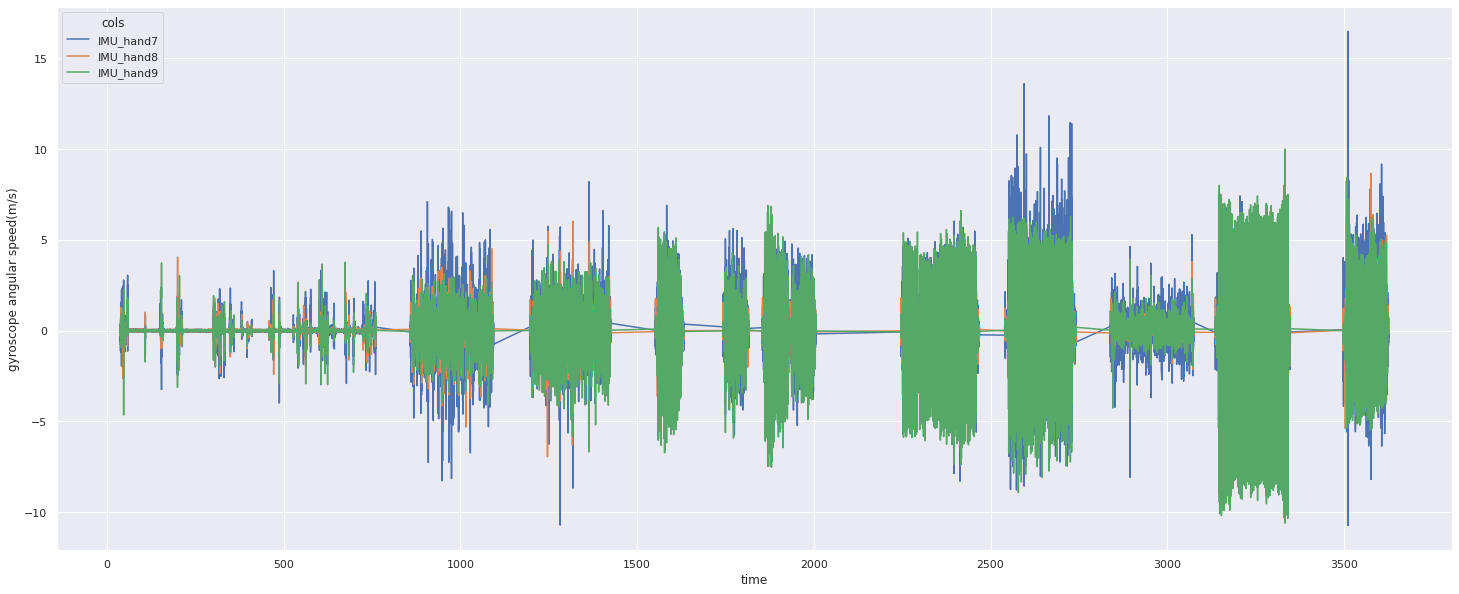

In [ ]:
fig = plt.gcf()
fig.set_size_inches(25, 10)

gyro_speed = subj101.melt(id_vars="time", value_vars=["IMU_hand7", "IMU_hand8", "IMU_hand9"] ,var_name="cols", value_name="gyroscope angular speed(m/s)")
p = sns.lineplot(data=gyro_speed, x="time", y="gyroscope angular speed(m/s)", hue="cols")

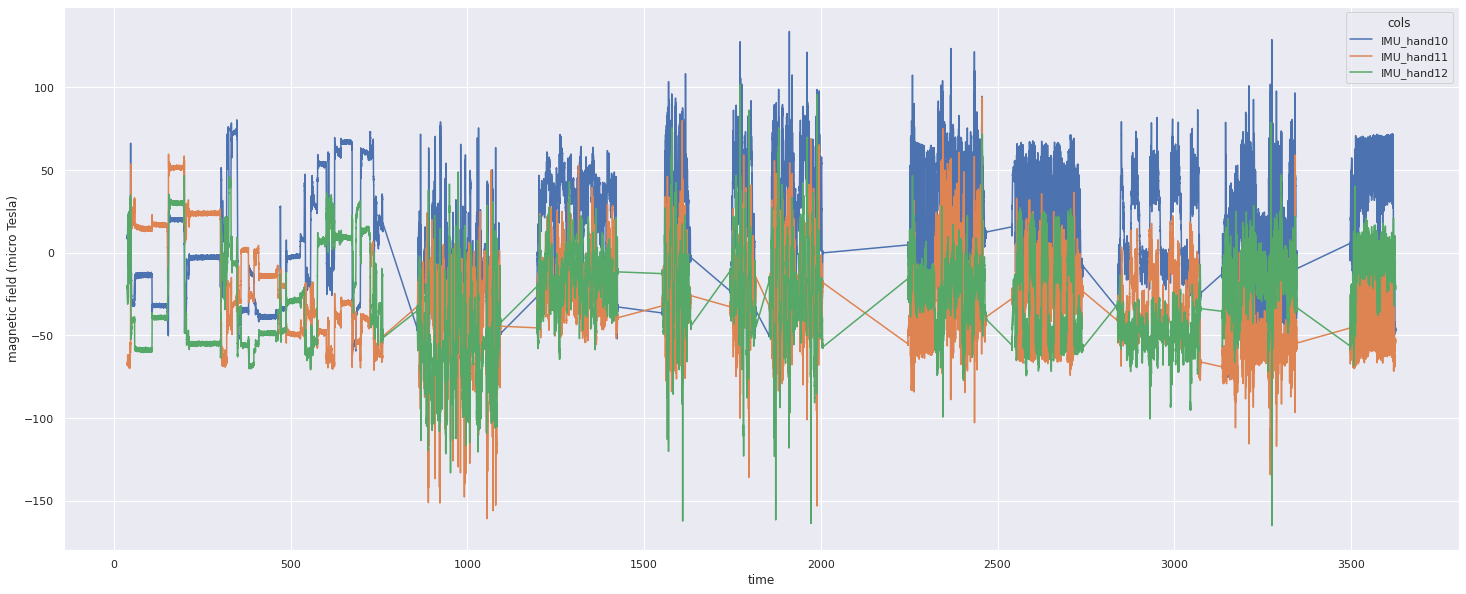

In [ ]:
fig = plt.gcf()
fig.set_size_inches(25, 10)

magnetic_field = subj101.melt(id_vars="time", value_vars=["IMU_hand10", "IMU_hand11", "IMU_hand12"] ,var_name="cols", value_name="magnetic field (micro Tesla)")
p = sns.lineplot(data=magnetic_field, x="time", y="magnetic field (micro Tesla)", hue="cols")

In [10]:
subj109.count()

time             6391
activity_id      6391
heart_rate        585
IMU_hand0        6389
IMU_hand1        6389
IMU_hand2        6389
IMU_hand3        6389
IMU_hand4        6389
IMU_hand5        6389
IMU_hand6        6389
IMU_hand7        6389
IMU_hand8        6389
IMU_hand9        6389
IMU_hand10       6389
IMU_hand11       6389
IMU_hand12       6389
IMU_chest0       6391
IMU_chest1       6391
IMU_chest2       6391
IMU_chest3       6391
IMU_chest4       6391
IMU_chest5       6391
IMU_chest6       6391
IMU_chest7       6391
IMU_chest8       6391
IMU_chest9       6391
IMU_chest10      6391
IMU_chest11      6391
IMU_chest12      6391
IMU_ankle0       6388
IMU_ankle1       6388
IMU_ankle2       6388
IMU_ankle3       6388
IMU_ankle4       6388
IMU_ankle5       6388
IMU_ankle6       6388
IMU_ankle7       6388
IMU_ankle8       6388
IMU_ankle9       6388
IMU_ankle10      6388
IMU_ankle11      6388
IMU_ankle12      6388
activity_name    6391
dtype: int64

Lastly we would like to take a look at the activity distribution along the entire data set.

In [ ]:
activities = [subj.activity_id.unique() for subj in subjects]
np.unique(np.concatenate(activities).ravel()).tolist()

[1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]

It seems that our data contains only a subset of the label space, we will need to transform the original label space into one that contains only these labels

# 1.c

We could attempt to use self supervision in order to fill the missing readings in any of the features. Though as we showed above, heart rate changes very slowly and as such is probably left to interpolation. Another use could be predicting the heart rate of the subject in the next time step.



# Model Evaluation Pipeline - 2.a

In the following few blocks we orenaize all the preprocessing we suggested above and create the means to load and process all of the data.
To evaluate our models we use 5 fold cross validation.
The data will consist of examples containing TIME_SAMPLE_SIZE time steps.

## Loading and Preprocessing

Here We apply all the steps we discusesd in the data analysis section as preprocessing steps wehn loading the data from disk.

The most interesting function in this code block is the `generate_examples` function. In this function we transform the tabular data as of each subject into an array of examples each containing TIME_SAMPLE_SIZE continues time steps of the same label, and of curse the labels in a seperate array. The functin creates these examples by sliding a TIME_SAMPLE_SIZE windows over each activities records. The MOVING_WINDOW_STRIDE variable decides how much the window moves between samples. For example for a stride of 100, the window will start at index 0 and take the first 200 time steps (0-199) as the first example, then move onto index 100 and take the next 200 time steps (100-299) as the second example. The smaller MOVING_WINDOW_STRIDE is, the more examples will be generated.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

TIME_SAMPLE_SIZE = 200
MOVING_WINDOW_STRIDE = 100

ACTIVITY_ID_TABLE = {
      1:0, 2:1, 3:2, 4:3, 5:4, 6:5,
      7:6, 12:7, 13:8, 16:9, 17:10, 24:11
}

R_ACTIVITY_ID_TABLE = {v: k for k, v in ACTIVITY_ID_TABLE.items()}

ID_NAME_MAP = {id: activity_map[R_ACTIVITY_ID_TABLE[id]] for id in R_ACTIVITY_ID_TABLE.keys()}

def activity_id_map(id, reverse=False):
  if id == 0:
    return 0

  if reverse:
    return R_ACTIVITY_ID_TABLE[id]
  
  return ACTIVITY_ID_TABLE[id]

def load_subject(number_str):
  subj = pd.read_csv("PAMAP2_Dataset/Protocol/subject" + number_str + ".dat", names=column_names, delim_whitespace=True) 
  # we remove all the IMU readings that are not relevant.
  for i in range(13, 17):
    subj = subj.drop(["IMU_hand" + str(i), "IMU_chest" + str(i), "IMU_ankle" + str(i)], axis=1)
  
  # the accelerometer readings we deemed irrelevent above.
  subj = subj.drop(["IMU_hand4", "IMU_hand5", "IMU_hand6"], axis=1)

  # we remove the invalid ids, and then map them into a dense space.
  subj = remove_invalid_ids(subj)
  subj["activity_id"] = subj["activity_id"].map(activity_id_map)
  return subj

def remove_invalid_ids(data):
  return data[data.activity_id != 0]

def interpolate_sensors(data):
  data.iloc[:, 2:42] = data.iloc[:, 2:42].interpolate(limit_direction='both')

def generate_examples(subject_data):
  activities = subject_data.activity_id.unique()
  samples = []
  labels = []
  for activity in activities:
    activity_data = subject_data[subject_data.activity_id == activity]
    time = activity_data.time.copy().values
    activity_time_groups = []
    last_time_jump = time[0]
    for i in range(1, len(time)):
      # if we see a jump in time we seperate the data up to the 
      # last continues reading from the rest of the data so that 
      # all samples will be continues.
      if abs(time[i] - 0.01 - time[i-1]) > 0.001:
        time_group = activity_data[(activity_data.time >= last_time_jump) & (activity_data.time <= time[i-1])]
        time_group = time_group.drop(columns=['time']) 
        activity_time_groups.append(time_group)
        last_time_jump = time[i] # the beginning of the new continues time group.
    
    # we add the remaining time group after all the splits.
    last_time_group = activity_data[activity_data.time >= last_time_jump]
    last_time_group = last_time_group.drop(columns=["time"])
    activity_time_groups.append(last_time_group)

    # now that each element in activity time_groups 
    # contains a continues section of time with only one activity
    # we can easily split each of these into smaller TIME_SAMPLE_SIZE element sections.

    # this is a draining iterator, removes all the activity time groups
    # and splits them into samples of TIME_SAMPLE_SIZE or less time steps.
    # the MOVING_WINDOW_STIDE controlls how much we jump forward before 
    # creating the next example.
    while activity_time_groups:
      group_data = activity_time_groups.pop()

      # all the activity_id's are the same because we 
      # made the groups this way. and so we take the first
      # acivity id as the label for this example.
      label = group_data["activity_id"].iloc[0]
      group_data = group_data.drop(columns=["activity_id"]).values
      for i in range(TIME_SAMPLE_SIZE,len(group_data), MOVING_WINDOW_STRIDE):
        labels.append(label)
        samples.append(group_data[i-TIME_SAMPLE_SIZE:i])
  
  return np.array(samples), np.array(labels)


def create_dataset(subject_list):
  features = []
  labels = np.array([])
  for subj_name in subject_list:
    subj = load_subject(subj_name)
    interpolate_sensors(subj)
    subj_features, subj_labels = generate_examples(subj)
    features.append(subj_features)
    labels = np.append(labels, subj_labels, 0)

  f_res = features[0]
  for i in range(1, len(features)):
    f_res = np.concatenate((f_res, features[i]), axis=0)

  labels = labels.astype(np.int32)
  f_res, labels = shuffle(f_res, labels)

  return f_res, labels

## Evaluation

We use wandb to log the models results and progress.

these lines turn off std output for wandb, to reduce clutter in the notebook.
```
os.environ['WANDB_CONSOLE'] = "off"
os.environ['WANDB_SILENT'] = "true"
```

In [ ]:
!pip install wandb -qqq
!wandb login
import os
os.environ['WANDB_CONSOLE'] = "off"
os.environ['WANDB_SILENT'] = "true"

In [ ]:
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score, f1_score

def ensumble_clf(pred_probs):
  '''
  This is a mean classefier, meaning it takes in the probabilities generated
  from the classifications of all the other models, and returns the mean of those 
  for each example.
  '''
  pred_probs = np.stack(pred_probs)
  return np.mean(pred_probs, axis=0)

def calculate_scores(true_values, pred_probs):
  pred_values = np.argmax(pred_probs, axis=1)

  acc = accuracy_score(true_values, pred_values)
  f1 = f1_score(true_values, pred_values, average='macro')

  return [
          ("accuracy", acc),
          ("f1 score", f1)
  ]

def evaluate_model(name, train, predict,
                   training,
                   testing,
                   validation=None,
                   log_config=None):
  print("----------------------------------------")
  print(f"evaluating {name} model")
  print("----------------------------------------")
  
  training_data, training_labels = training
  testing_data, testing_labels = testing

  kf = KFold(n_splits=5)
  fold_num = 1
  test_pred = []

  for train_index, val_index in kf.split(training_data):
    x_train = training_data[train_index]
    y_train = training_labels[train_index]

    if validation:
      x_val, y_val = validation
    else:
      x_val = training_data[val_index]
      y_val = training_labels[val_index]

    if log_config:
      wandb.init(
          project='dl_assignment2',
          group=name,
          name=name + "-fold-" + str(fold_num),
          config=log_config
      )
      model = train(x_train, y_train, (x_val, y_val), WandbCallback())
    else:
      model = train(x_train, y_train, (x_val, y_val))

    val_pred_probs = predict(model, x_val)
    val_scores = calculate_scores(y_val, val_pred_probs)

    print("----------------------------------------")
    print(f"validation results for fold numer {fold_num}:")
    for metric, score in val_scores:
      print(f"  {metric}: {score}")
    print()

    test_pred_probs = predict(model, testing_data)
    test_scores = calculate_scores(testing_labels, test_pred_probs)
    print(f"test results for fold numer {fold_num}:")
    for metric, score in test_scores:
      print(f"  {metric}: {score}")
    print("----------------------------------------")

    if log_config:
      val_calss_pred = np.argmax(val_pred_probs, axis=1)
      test_class_pred = np.argmax(test_pred_probs, axis=1)

      wandb.log({"validation " + metric: score for (metric, score) in val_scores}, commit=False)
      wandb.log({"test " + metric: score for (metric, score) in test_scores}, commit=False)
      wandb.log({"validation confution matrix": wandb.plot.confusion_matrix(val_calss_pred, y_val, list(ID_NAME_MAP.values()))}, commit=False)
      wandb.log({"testing confution matrix": wandb.plot.confusion_matrix(test_class_pred, testing_labels, list(ID_NAME_MAP.values()))})
      wandb.finish()

    test_pred.append(test_pred_probs)
    fold_num += 1

  ensumble_pred_probs = ensumble_clf(test_pred)
  test_scores = calculate_scores(testing_labels, ensumble_pred_probs)
  print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
  print(f"ensumble test results:")
  for metric, score in test_scores:
    print(f"  {metric}: {score}")
  print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

  if log_config:
    wandb.init(
        project='dl_assignment2',
        group=name,
        name=name + "-ensumble",
        config=log_config
    )
    ensumble_class_pred = np.argmax(ensumble_pred_probs, axis=1)
    wandb.log({"test " + metric: score for (metric, score) in test_scores}, commit=False)
    wandb.log({"testing confution matrix": wandb.plot.confusion_matrix(ensumble_class_pred, testing_labels, list(ID_NAME_MAP.values()))})
    wandb.finish()

# Classical ML models

### Naive Baseline - 2.b

We first load the data, and then flatten it to adapt it for classical ml algorithms

In [ ]:
MOVING_WINDOW_STRIDE = 200

training_data, training_labels = create_dataset(["101", "102", "103", "104", "105", "106"])
testing_data, testing_labels = create_dataset(["107", "108"])

def flateen_dataset(data, labels):
  flattened_data = []
  flattened_labels = []
  for i in range(len(data)):
    for example in data[i]:
      flattened_data.append(example)
      flattened_labels.append(labels[i])

  return np.array(flattened_data), np.array(flattened_labels)
  
flat_training_data, flat_training_labels = flateen_dataset(training_data, training_labels)
flat_test_data, flat_test_labels = flateen_dataset(testing_data, testing_labels)

In [ ]:
class Baseline:

  def __init__(self, labels):
    zeros = np.zeros(len(ACTIVITY_ID_TABLE))
    for i in range(len(ACTIVITY_ID_TABLE)):
      zeros[i] = (labels == i).sum()
      if not zeros[i] == 0:
        zeros[i] = zeros[i] / len(labels) 
    
    self.label_probs = zeros

  def pred(self, features):
    def sigmoid(z):
      return 1/(1 + np.exp(-z))

    zeros = np.zeros((len(features), len(ACTIVITY_ID_TABLE)))
    zeros = zeros.T
    for i in range(len(ACTIVITY_ID_TABLE)):
      zeros[i] = sigmoid(np.random.normal(loc=self.label_probs[i], size=len(features)))
    return zeros.T

def train_baseline(data, labels, validation=None, log_callback=None):
  return Baseline(labels)

def predict_baseline(model, data):
  return model.pred(data)

evaluate_model("Baseline",
               train_baseline,
               predict_baseline,
               (flat_training_data, flat_training_labels),
               (flat_test_data, flat_test_labels))

----------------------------------------
evaluating Baseline model
----------------------------------------
----------------------------------------
validation results for fold numer 1:
  accuracy: 0.08523538052602127
  f1 score: 0.08147828086204034

test results for fold numer 1:
  accuracy: 0.08501528117359414
  f1 score: 0.07980258894215199
----------------------------------------
----------------------------------------
validation results for fold numer 2:
  accuracy: 0.08400776440962507
  f1 score: 0.08020619191981009

test results for fold numer 2:
  accuracy: 0.0853158109209454
  f1 score: 0.08005053452878887
----------------------------------------
----------------------------------------
validation results for fold numer 3:
  accuracy: 0.08479469781757135
  f1 score: 0.08149452962379372

test results for fold numer 3:
  accuracy: 0.08475448247758761
  f1 score: 0.07948401836379775
----------------------------------------
----------------------------------------
validation resu

Obisly the accuracy of this algorithm wont be great, but a 8.5-8.8% accuracy is not a bad start.

### SGD - 2.c

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_config = {
      "max_iter": 10,
      "loss": 'log'
}

def train_sgd(data, labels, validation=None, log_callback=None):
  clf = SGDClassifier(max_iter=5, loss='log', n_jobs=4)
  clf.fit(data, labels)
  return clf

def predictsgd(model, data):
  return model.predict_proba(data)

evaluate_model("Stochastic Gradient Descent",
               train_sgd,
               predictsgd,
               (flat_training_data, flat_training_labels),
               (flat_test_data, flat_test_labels),
               log_config=sgd_config)

----------------------------------------
evaluating Stochastic Gradient Descent model
----------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


----------------------------------------
validation results for fold numer 1:
  accuracy: 0.6874529091670155
  f1 score: 0.6591721961587654

test results for fold numer 1:
  accuracy: 0.49805691056910567
  f1 score: 0.4290155382546382
----------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


----------------------------------------
validation results for fold numer 2:
  accuracy: 0.5602204548625646
  f1 score: 0.5314799486615692

test results for fold numer 2:
  accuracy: 0.39142073170731706
  f1 score: 0.3009263779790067
----------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


----------------------------------------
validation results for fold numer 3:
  accuracy: 0.653802148737268
  f1 score: 0.6066743349094844

test results for fold numer 3:
  accuracy: 0.3514227642276423
  f1 score: 0.2688787233976719
----------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


----------------------------------------
validation results for fold numer 4:
  accuracy: 0.6842298032649644
  f1 score: 0.6562366659902559

test results for fold numer 4:
  accuracy: 0.367880081300813
  f1 score: 0.28736149660121796
----------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


----------------------------------------
validation results for fold numer 5:
  accuracy: 0.6311671550160458
  f1 score: 0.6059437635532805

test results for fold numer 5:
  accuracy: 0.5771788617886179
  f1 score: 0.48821782731103025
----------------------------------------


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ensumble test results:
  accuracy: 0.4719410569105691
  f1 score: 0.4005329453067908
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


Using this very simple model we can see very high accuracy results for the validation set, though it seems that the test results are much worse.
We discuss this in more detail here - https://wandb.ai/zshoham/dl_assignment2/reports/Analysis-of-SGD-Results--VmlldzozNzQ4NDA

# Deep Learning Models

We use a MOVING_WINDOW_STRIDE of 100 here as it gives a decent amount of examples and yet does not overload the RAM or cause the models to train for a very long time.

Another note is the dimension expansion for the data. This is done for the CNN models because CNN's expects an additional channel dimension

In [ ]:
MOVING_WINDOW_STRIDE = 100

training_data, training_labels = create_dataset(["101", "102", "103", "104", "105", "106"])
testing_data, testing_labels = create_dataset(["107", "108"])

training_data_extended = np.expand_dims(training_data, -1)
testing_data_extended = np.expand_dims(testing_data, -1)

## Shallow CNN - 2.d

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

cnn_config = {
      "optimizer": 'adam',
      "loss": 'sparse_categorical_crossentropy',
      "batch_size": 100,
      "epochs": 20
  }

def cnn():
  return keras.Sequential([
      layers.Input((TIME_SAMPLE_SIZE, training_data.shape[2], 1)),
      layers.BatchNormalization(),
      layers.Conv2D(16, 3, activation='relu', padding='same'),
      layers.MaxPool2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.AveragePooling2D(),
      layers.Flatten(),
      layers.Dense(len(ACTIVITY_ID_TABLE), activation='softmax')
  ])

def train_cnn(data, labels, validation=None, log_callback=None):
  model = cnn()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  model.fit(data, labels, batch_size=100, epochs=20,
            verbose=1, validation_data=validation, callbacks=[log_callback])
  return model

def predict_cnn(model, data):
  return model.predict(data)

cnn().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 200, 37, 1)        4         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 37, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 18, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 16, 32)        4640      
_________________________________________________________________
average_pooling2d (AveragePo (None, 49, 8, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 12)                1

In [ ]:
evaluate_model("Shallow CNN",
               train_cnn,
               predict_cnn,
               (training_data_extended, training_labels),
               (testing_data_extended, testing_labels),
               log_config=cnn_config)

----------------------------------------
evaluating Shallow CNN model
----------------------------------------


Epoch 1/20
115/115 [==============================] - 2s 17ms/step - loss: 1.4947 - accuracy: 0.5244 - val_loss: 0.7178 - val_accuracy: 0.7811
Epoch 2/20
115/115 [==============================] - 2s 13ms/step - loss: 0.4950 - accuracy: 0.8564 - val_loss: 0.4355 - val_accuracy: 0.8759
Epoch 3/20
115/115 [==============================] - 2s 13ms/step - loss: 0.3543 - accuracy: 0.9039 - val_loss: 0.3528 - val_accuracy: 0.9042
Epoch 4/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2643 - accuracy: 0.9269 - val_loss: 0.3127 - val_accuracy: 0.9136
Epoch 5/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2215 - accuracy: 0.9360 - val_loss: 0.2531 - val_accuracy: 0.9290
Epoch 6/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2082 - accuracy: 0.9418 - val_loss: 0.2714 - val_accuracy: 0.9185
Epoch 7/20
115/115 [==============================] - 2s 13ms/step - loss: 0.1836 - accuracy: 0.9469 - val_loss: 0.2299 - val_accuracy: 0.9374

Epoch 1/20
115/115 [==============================] - 2s 16ms/step - loss: 1.5244 - accuracy: 0.5252 - val_loss: 0.6843 - val_accuracy: 0.7856
Epoch 2/20
115/115 [==============================] - 2s 14ms/step - loss: 0.5358 - accuracy: 0.8454 - val_loss: 0.3960 - val_accuracy: 0.8772
Epoch 3/20
115/115 [==============================] - 2s 13ms/step - loss: 0.3837 - accuracy: 0.8916 - val_loss: 0.3411 - val_accuracy: 0.9003
Epoch 4/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2997 - accuracy: 0.9156 - val_loss: 0.3356 - val_accuracy: 0.9049
Epoch 5/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2679 - accuracy: 0.9254 - val_loss: 0.3049 - val_accuracy: 0.9077
Epoch 6/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2285 - accuracy: 0.9386 - val_loss: 0.2938 - val_accuracy: 0.9108
Epoch 7/20
115/115 [==============================] - 2s 15ms/step - loss: 0.2097 - accuracy: 0.9379 - val_loss: 0.2243 - val_accuracy: 0.9363

Epoch 1/20
115/115 [==============================] - 2s 16ms/step - loss: 1.5794 - accuracy: 0.5029 - val_loss: 0.5597 - val_accuracy: 0.8297
Epoch 2/20
115/115 [==============================] - 2s 13ms/step - loss: 0.5203 - accuracy: 0.8513 - val_loss: 0.4096 - val_accuracy: 0.8734
Epoch 3/20
115/115 [==============================] - 2s 13ms/step - loss: 0.3663 - accuracy: 0.8948 - val_loss: 0.2822 - val_accuracy: 0.9189
Epoch 4/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2909 - accuracy: 0.9196 - val_loss: 0.2634 - val_accuracy: 0.9241
Epoch 5/20
115/115 [==============================] - 2s 15ms/step - loss: 0.2536 - accuracy: 0.9279 - val_loss: 0.2185 - val_accuracy: 0.9346
Epoch 6/20
115/115 [==============================] - 2s 13ms/step - loss: 0.1878 - accuracy: 0.9454 - val_loss: 0.2298 - val_accuracy: 0.9325
Epoch 7/20
115/115 [==============================] - 2s 13ms/step - loss: 0.1822 - accuracy: 0.9495 - val_loss: 0.2078 - val_accuracy: 0.9367

Epoch 1/20
115/115 [==============================] - 2s 16ms/step - loss: 1.5025 - accuracy: 0.5319 - val_loss: 0.7124 - val_accuracy: 0.7961
Epoch 2/20
115/115 [==============================] - 2s 13ms/step - loss: 0.5095 - accuracy: 0.8542 - val_loss: 0.4599 - val_accuracy: 0.8807
Epoch 3/20
115/115 [==============================] - 2s 15ms/step - loss: 0.3713 - accuracy: 0.9003 - val_loss: 0.3603 - val_accuracy: 0.8961
Epoch 4/20
115/115 [==============================] - 2s 14ms/step - loss: 0.3014 - accuracy: 0.9185 - val_loss: 0.3158 - val_accuracy: 0.9157
Epoch 5/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2416 - accuracy: 0.9356 - val_loss: 0.2855 - val_accuracy: 0.9129
Epoch 6/20
115/115 [==============================] - 2s 14ms/step - loss: 0.2181 - accuracy: 0.9403 - val_loss: 0.2979 - val_accuracy: 0.9112
Epoch 7/20
115/115 [==============================] - 2s 13ms/step - loss: 0.1921 - accuracy: 0.9482 - val_loss: 0.2531 - val_accuracy: 0.9217

Epoch 1/20
115/115 [==============================] - 2s 16ms/step - loss: 1.5443 - accuracy: 0.5244 - val_loss: 0.7319 - val_accuracy: 0.7674
Epoch 2/20
115/115 [==============================] - 2s 13ms/step - loss: 0.4662 - accuracy: 0.8688 - val_loss: 0.3451 - val_accuracy: 0.8986
Epoch 3/20
115/115 [==============================] - 2s 13ms/step - loss: 0.3389 - accuracy: 0.9073 - val_loss: 0.3061 - val_accuracy: 0.9140
Epoch 4/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2758 - accuracy: 0.9258 - val_loss: 0.2702 - val_accuracy: 0.9300
Epoch 5/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2279 - accuracy: 0.9383 - val_loss: 0.2547 - val_accuracy: 0.9437
Epoch 6/20
115/115 [==============================] - 2s 13ms/step - loss: 0.2131 - accuracy: 0.9414 - val_loss: 0.2416 - val_accuracy: 0.9283
Epoch 7/20
115/115 [==============================] - 2s 15ms/step - loss: 0.1776 - accuracy: 0.9507 - val_loss: 0.2134 - val_accuracy: 0.9391

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ensumble test results:
  accuracy: 0.7284026079869601
  f1 score: 0.650809894687718
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


We can see that the CNN model does much better, achieving validation accuracies greater than 0.9. On the other hand, although the test scores have improved significantly from the SGD model, they are still much lower than the validation scores. A discussion of the results is available here - https://wandb.ai/zshoham/dl_assignment2/reports/Analysis-of-Shallow-CNN-Results--VmlldzozNzQ4OTk

## Self Supervised Heart Rate Regressor - 2.e

We chose to train a model that predicts the heart rate in the next time step for our self supervised task.

To do this, we had to reorganize the data a little. First, we removed the last time step from each example in the data. The heart rate in this time step will be the one we try to predict. This leaves us with 199 time-steps per instance. Next, we take the heart rate from the time step we extracted and make it the instance's label.

In [ ]:
def to_heart_rate_task(data):
  new_data = []
  new_labels = []
  for sample in data:
    new_labels.append(sample[-1][0][0])
    new_data.append(sample[:-1]) 
  
  return np.array(new_data), np.array(new_labels)

hr_training_data, hr_training_labels = to_heart_rate_task(training_data_extended)
hr_testing_data, hr_testing_labels = to_heart_rate_task(testing_data_extended) 

In this model, we use a different shape than the classifier. The temporal dimension is 199 long instead of 200. To make it possible to use this model in a classifier later, we use a `None` for the temporal dimension size and replace the Flatten layer with a concatenation of global average and max-pooling layers.

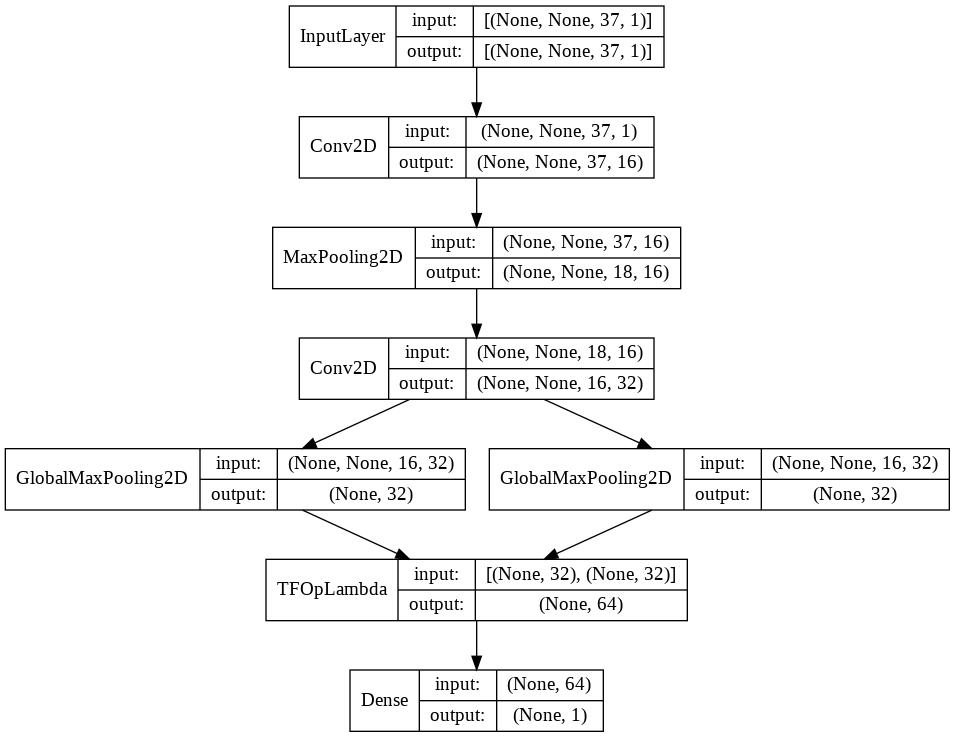

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

inputs = layers.Input((None, hr_training_data.shape[2], 1))
x = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
average = layers.GlobalMaxPooling2D()(x)
max = layers.GlobalMaxPool2D()(x)
x = tf.concat([average, max], axis=1)
output = layers.Dense(1, activation='linear')(x)

hr_regressor = keras.Model(inputs=inputs, outputs=output, name="heart_rate_regressor")

hr_regressor.compile(optimizer='adam', loss='mse', metrics=['mae'])

keras.utils.plot_model(hr_regressor, show_shapes=True, show_layer_names=False)

In [ ]:
hr_regressor.fit(hr_training_data, hr_training_labels, epochs=20, batch_size=100)

Epoch 1/20
143/143 [==============================] - 9s 12ms/step - loss: 2435.5702 - mae: 32.9200
Epoch 2/20
143/143 [==============================] - 2s 11ms/step - loss: 33.5952 - mae: 4.2461
Epoch 3/20
143/143 [==============================] - 2s 11ms/step - loss: 14.7472 - mae: 2.8111
Epoch 4/20
143/143 [==============================] - 2s 11ms/step - loss: 7.2047 - mae: 1.9344
Epoch 5/20
143/143 [==============================] - 2s 11ms/step - loss: 3.8561 - mae: 1.3833
Epoch 6/20
143/143 [==============================] - 2s 11ms/step - loss: 2.3210 - mae: 1.0755
Epoch 7/20
143/143 [==============================] - 2s 11ms/step - loss: 1.7746 - mae: 0.9396
Epoch 8/20
143/143 [==============================] - 2s 11ms/step - loss: 1.5281 - mae: 0.8530
Epoch 9/20
143/143 [==============================] - 2s 11ms/step - loss: 1.2690 - mae: 0.7831
Epoch 10/20
143/143 [==============================] - 2s 11ms/step - loss: 1.1515 - mae: 0.7447
Epoch 11/20
143/143 [============

In [ ]:
test_mse, test_mae = hr_regressor.evaluate(hr_testing_data, hr_testing_labels)
print("test mse: ", test_mse)
print("test mae: ", test_mae)

154/154 [==============================] - 1s 3ms/step - loss: 1.2265 - mae: 0.6638
test mse:  1.2264915704727173
test mae:  0.663780927658081


The mean absolute error on the test set is 0.66. This is excellent, considering we did not normalize the network's data, meaning we get within less than one heartbeat from the correct heart rate.

Next, we take the trained regressor and fine-tune it for predicting the user's activity. As mentioned before, this works because we designed the regressor to accept any size in the temporal dimension. We also add a dense layer after the regressor to transform the data between the tasks.

In [ ]:
ft_regressor_config = {
  "optimizer": 'adam',
  "loss": 'sparse_categorical_crossentropy',
  "batch_size": 20,
  "epochs": 20
}

def ft_regressor():
  hr_regressor.trainable = False
  x = hr_regressor.layers[-3].output
  x = layers.BatchNormalization()(x)
  x = layers.Dense(32, activation='relu')(x)
  output = layers.Dense(len(ACTIVITY_ID_TABLE), activation='softmax')(x)
  return keras.Model(inputs=hr_regressor.input, outputs=output, name="fine_tuned_regressor")

def train_ft_regressor(data, labels, validation=None, log_callback=None):
  model = ft_regressor()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  model.fit(data, labels, batch_size=20, epochs=20,
            verbose=1, validation_data=validation, callbacks=[log_callback])
  return model

def predict_ft_regressor(model, data):
  return model.predict(data)

ft_regressor().summary()

Model: "fine_tuned_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 37, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, 37, 16)      160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, None, 18, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, 16, 32)      4640      
_________________________________________________________________
global_max_pooling2d_11 (Glo (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_12 (Dense)             (None, 32)       

In [ ]:
evaluate_model("Fine Tuned CNN Regressor",
              train_ft_regressor,
              predict_ft_regressor,
              (training_data_extended, training_labels),
              (testing_data_extended, testing_labels),
              log_config=ft_regressor_config)

----------------------------------------
evaluating Fine Tuned CNN Regressor model
----------------------------------------
Epoch 1/20
572/572 [==============================] - 3s 4ms/step - loss: 1.7460 - accuracy: 0.4396 - val_loss: 1.0334 - val_accuracy: 0.7010
Epoch 2/20
572/572 [==============================] - 2s 4ms/step - loss: 1.0522 - accuracy: 0.6750 - val_loss: 0.8996 - val_accuracy: 0.7241
Epoch 3/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9831 - accuracy: 0.6879 - val_loss: 0.8548 - val_accuracy: 0.7367
Epoch 4/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9091 - accuracy: 0.7062 - val_loss: 0.8104 - val_accuracy: 0.7497
Epoch 5/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8841 - accuracy: 0.7169 - val_loss: 0.7892 - val_accuracy: 0.7521
Epoch 6/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8609 - accuracy: 0.7279 - val_loss: 0.7510 - val_accuracy: 0.7717
Epoch 7/20
572/572 [====

Epoch 1/20
572/572 [==============================] - 3s 4ms/step - loss: 1.8837 - accuracy: 0.3729 - val_loss: 1.0442 - val_accuracy: 0.6849
Epoch 2/20
572/572 [==============================] - 2s 4ms/step - loss: 1.0732 - accuracy: 0.6694 - val_loss: 0.8921 - val_accuracy: 0.7412
Epoch 3/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9706 - accuracy: 0.6962 - val_loss: 0.8203 - val_accuracy: 0.7653
Epoch 4/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9033 - accuracy: 0.7116 - val_loss: 0.7780 - val_accuracy: 0.7726
Epoch 5/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8946 - accuracy: 0.7143 - val_loss: 0.7490 - val_accuracy: 0.7786
Epoch 6/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8642 - accuracy: 0.7327 - val_loss: 0.7205 - val_accuracy: 0.7852
Epoch 7/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8387 - accuracy: 0.7323 - val_loss: 0.7037 - val_accuracy: 0.7982
Epoch 

Epoch 1/20
572/572 [==============================] - 3s 4ms/step - loss: 1.9654 - accuracy: 0.3535 - val_loss: 1.0443 - val_accuracy: 0.7027
Epoch 2/20
572/572 [==============================] - 2s 4ms/step - loss: 1.0626 - accuracy: 0.6721 - val_loss: 0.9042 - val_accuracy: 0.7370
Epoch 3/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9534 - accuracy: 0.7028 - val_loss: 0.8494 - val_accuracy: 0.7464
Epoch 4/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9200 - accuracy: 0.7052 - val_loss: 0.8194 - val_accuracy: 0.7538
Epoch 5/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8859 - accuracy: 0.7236 - val_loss: 0.7913 - val_accuracy: 0.7698
Epoch 6/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8648 - accuracy: 0.7207 - val_loss: 0.7797 - val_accuracy: 0.7660
Epoch 7/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8625 - accuracy: 0.7298 - val_loss: 0.7502 - val_accuracy: 0.7800
Epoch 

Epoch 1/20
572/572 [==============================] - 3s 4ms/step - loss: 1.8611 - accuracy: 0.3895 - val_loss: 1.0370 - val_accuracy: 0.7135
Epoch 2/20
572/572 [==============================] - 2s 4ms/step - loss: 1.0799 - accuracy: 0.6555 - val_loss: 0.9024 - val_accuracy: 0.7349
Epoch 3/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9502 - accuracy: 0.6914 - val_loss: 0.8561 - val_accuracy: 0.7433
Epoch 4/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9162 - accuracy: 0.7028 - val_loss: 0.8102 - val_accuracy: 0.7587
Epoch 5/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8888 - accuracy: 0.7173 - val_loss: 0.7754 - val_accuracy: 0.7527
Epoch 6/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8838 - accuracy: 0.7118 - val_loss: 0.7462 - val_accuracy: 0.7772
Epoch 7/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8378 - accuracy: 0.7335 - val_loss: 0.7146 - val_accuracy: 0.7908
Epoch 

Epoch 1/20
572/572 [==============================] - 3s 4ms/step - loss: 1.8681 - accuracy: 0.3975 - val_loss: 1.0267 - val_accuracy: 0.7027
Epoch 2/20
572/572 [==============================] - 2s 4ms/step - loss: 1.0639 - accuracy: 0.6651 - val_loss: 0.8876 - val_accuracy: 0.7401
Epoch 3/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9468 - accuracy: 0.7036 - val_loss: 0.8280 - val_accuracy: 0.7562
Epoch 4/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9043 - accuracy: 0.7113 - val_loss: 0.7911 - val_accuracy: 0.7583
Epoch 5/20
572/572 [==============================] - 2s 4ms/step - loss: 0.9063 - accuracy: 0.7154 - val_loss: 0.7650 - val_accuracy: 0.7719
Epoch 6/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8665 - accuracy: 0.7310 - val_loss: 0.7408 - val_accuracy: 0.7779
Epoch 7/20
572/572 [==============================] - 2s 4ms/step - loss: 0.8438 - accuracy: 0.7329 - val_loss: 0.7347 - val_accuracy: 0.7782
Epoch 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ensumble test results:
  accuracy: 0.5821108394458028
  f1 score: 0.5507949009665004
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


It looks like the classification model isn't doing too well, though the validation accuracies are relatively good at around 0.8, though still less than the original CNN classifier. This probably means that the self-supervised task we chose does not generalize well to the data and activities in particular.

## 2.f

As discussed before, we believe that with some more data on different subjects, we could probably improve the model's test accuracies significantly. But if we are talking about modifications we can make ourselves, we have some ideas:

* The first is very simple, improving the CNN model by making it deeper, adding more connections, et cetera. The shallow model is minimal and has much room for experimentation.

* Secondly, we could try different model architectures. Time series tasks are generally thought to benefit from RNN architectures. 

* Finally, we could always optimize the model by changing hyperparameters like batch size, optimizer, and the number of epochs.

## 2.g

We chose to implement the first and second options, meaning we will attempt to create two more models. A deeper CNN model, and an RNN model.
The next two sections contain those models.
A summary and comparison of the algorithm is available here - https://wandb.ai/zshoham/dl_assignment2/reports/Summarizing-Report-for-Activity-Classification--VmlldzozNzQ5NDY

Additionally, a table with all of our runs is available here - https://wandb.ai/zshoham/dl_assignment2/table?workspace=user-zshoham

## Deep CNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers


deep_cnn_config = {
      "optimizer": 'adam',
      "loss": 'sparse_categorical_crossentropy',
      "batch_size": 100,
      "epochs": 20
}

def deep_cnn():
    return keras.Sequential([
      layers.Input((TIME_SAMPLE_SIZE, training_data.shape[2], 1)),
      layers.BatchNormalization(),
      layers.Conv2D(16, 3, activation='relu', padding='same'),
      layers.Conv2D(32, 3, activation='relu', padding='same'),
      layers.MaxPool2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.Conv2D(64, 3, activation='relu'),
      layers.AveragePooling2D(),
      layers.Flatten(),
      layers.Dropout(0.5),
      layers.Dense(len(ACTIVITY_ID_TABLE), activation='softmax')
  ])

def train_deep_cnn(data, labels, validation=None, log_callback=None):
  model = deep_cnn()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  model.fit(data, labels, batch_size=100, epochs=20,
            verbose=1, validation_data=validation, callbacks=[log_callback])
  return model

def predict_deep_cnn(model, data):
  return model.predict(data)

deep_cnn().summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 200, 37, 1)        4         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 200, 37, 16)       160       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 200, 37, 32)       4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 100, 18, 32)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 98, 16, 32)        9248      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 96, 14, 64)        18496     
_________________________________________________________________
average_pooling2d_19 (Averag (None, 48, 7, 64)       

In [ ]:
evaluate_model("Deep CNN",
               train_deep_cnn,
               predict_deep_cnn,
               (training_data_extended, training_labels),
               (testing_data_extended, testing_labels),
               log_config=deep_cnn_config)

----------------------------------------
evaluating Deep CNN model
----------------------------------------


Epoch 1/20
115/115 [==============================] - 5s 37ms/step - loss: 1.4874 - accuracy: 0.5192 - val_loss: 0.5324 - val_accuracy: 0.8367
Epoch 2/20
115/115 [==============================] - 4s 33ms/step - loss: 0.4444 - accuracy: 0.8661 - val_loss: 0.3718 - val_accuracy: 0.9014
Epoch 3/20
115/115 [==============================] - 4s 35ms/step - loss: 0.3214 - accuracy: 0.9043 - val_loss: 0.2760 - val_accuracy: 0.9206
Epoch 4/20
115/115 [==============================] - 4s 34ms/step - loss: 0.2223 - accuracy: 0.9365 - val_loss: 0.2501 - val_accuracy: 0.9287
Epoch 5/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1771 - accuracy: 0.9499 - val_loss: 0.2279 - val_accuracy: 0.9336
Epoch 6/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1467 - accuracy: 0.9593 - val_loss: 0.2055 - val_accuracy: 0.9371
Epoch 7/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1182 - accuracy: 0.9638 - val_loss: 0.1599 - val_accuracy: 0.9514

Epoch 1/20
115/115 [==============================] - 5s 38ms/step - loss: 1.4455 - accuracy: 0.5278 - val_loss: 0.6447 - val_accuracy: 0.7940
Epoch 2/20
115/115 [==============================] - 4s 34ms/step - loss: 0.4478 - accuracy: 0.8612 - val_loss: 0.3419 - val_accuracy: 0.8944
Epoch 3/20
115/115 [==============================] - 4s 34ms/step - loss: 0.3124 - accuracy: 0.9040 - val_loss: 0.2570 - val_accuracy: 0.9279
Epoch 4/20
115/115 [==============================] - 4s 34ms/step - loss: 0.2254 - accuracy: 0.9344 - val_loss: 0.2018 - val_accuracy: 0.9433
Epoch 5/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1728 - accuracy: 0.9457 - val_loss: 0.1997 - val_accuracy: 0.9405
Epoch 6/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1639 - accuracy: 0.9499 - val_loss: 0.1622 - val_accuracy: 0.9493
Epoch 7/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1214 - accuracy: 0.9618 - val_loss: 0.1628 - val_accuracy: 0.9468

Epoch 1/20
115/115 [==============================] - 5s 35ms/step - loss: 1.5025 - accuracy: 0.4922 - val_loss: 0.8283 - val_accuracy: 0.7261
Epoch 2/20
115/115 [==============================] - 4s 35ms/step - loss: 0.4358 - accuracy: 0.8700 - val_loss: 0.3275 - val_accuracy: 0.8937
Epoch 3/20
115/115 [==============================] - 4s 33ms/step - loss: 0.3033 - accuracy: 0.9114 - val_loss: 0.2043 - val_accuracy: 0.9346
Epoch 4/20
115/115 [==============================] - 4s 34ms/step - loss: 0.2050 - accuracy: 0.9367 - val_loss: 0.2012 - val_accuracy: 0.9349
Epoch 5/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1931 - accuracy: 0.9369 - val_loss: 0.1536 - val_accuracy: 0.9521
Epoch 6/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1375 - accuracy: 0.9569 - val_loss: 0.1411 - val_accuracy: 0.9493
Epoch 7/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1211 - accuracy: 0.9633 - val_loss: 0.1392 - val_accuracy: 0.9552

Epoch 1/20
115/115 [==============================] - 5s 35ms/step - loss: 1.4929 - accuracy: 0.5102 - val_loss: 0.7167 - val_accuracy: 0.7919
Epoch 2/20
115/115 [==============================] - 4s 33ms/step - loss: 0.4345 - accuracy: 0.8683 - val_loss: 0.5874 - val_accuracy: 0.8241
Epoch 3/20
115/115 [==============================] - 4s 33ms/step - loss: 0.3470 - accuracy: 0.8999 - val_loss: 0.3217 - val_accuracy: 0.8961
Epoch 4/20
115/115 [==============================] - 4s 35ms/step - loss: 0.2610 - accuracy: 0.9191 - val_loss: 0.2484 - val_accuracy: 0.9279
Epoch 5/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1987 - accuracy: 0.9406 - val_loss: 0.2369 - val_accuracy: 0.9248
Epoch 6/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1681 - accuracy: 0.9477 - val_loss: 0.1920 - val_accuracy: 0.9440
Epoch 7/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1364 - accuracy: 0.9555 - val_loss: 0.1606 - val_accuracy: 0.9458

Epoch 1/20
115/115 [==============================] - 5s 35ms/step - loss: 1.5041 - accuracy: 0.5201 - val_loss: 0.5339 - val_accuracy: 0.8349
Epoch 2/20
115/115 [==============================] - 4s 33ms/step - loss: 0.4516 - accuracy: 0.8632 - val_loss: 0.3128 - val_accuracy: 0.9189
Epoch 3/20
115/115 [==============================] - 4s 33ms/step - loss: 0.3087 - accuracy: 0.9092 - val_loss: 0.2441 - val_accuracy: 0.9325
Epoch 4/20
115/115 [==============================] - 4s 34ms/step - loss: 0.2456 - accuracy: 0.9294 - val_loss: 0.2245 - val_accuracy: 0.9307
Epoch 5/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1946 - accuracy: 0.9422 - val_loss: 0.1830 - val_accuracy: 0.9465
Epoch 6/20
115/115 [==============================] - 4s 35ms/step - loss: 0.1576 - accuracy: 0.9525 - val_loss: 0.1694 - val_accuracy: 0.9507
Epoch 7/20
115/115 [==============================] - 4s 34ms/step - loss: 0.1338 - accuracy: 0.9563 - val_loss: 0.1522 - val_accuracy: 0.9514

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ensumble test results:
  accuracy: 0.7559087204563977
  f1 score: 0.6877160170681625
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


Looking at the results, we can see an improvement over the shallow CNN model, the validation accuracies are consistently around 0.97, and the test accuracy increased to 0.75. Though it seems that this model could not generalize over subjects, it hasn't seen significantly better than the shallow CNN.

## RNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

lstm_config = {
      "optimizer": 'adam',
      "loss": 'sparse_categorical_crossentropy',
      "batch_size": 100,
      "epochs": 10
  }

def lstm():
    return keras.Sequential([
      layers.Input((TIME_SAMPLE_SIZE, training_data.shape[2])),
      layers.BatchNormalization(),
      layers.GRU(512, return_sequences=True),
      layers.Dropout(0.5),
      layers.GRU(256, return_sequences=True),
      layers.Dropout(0.5),
      layers.GRU(128),
      layers.BatchNormalization(),
      layers.Dropout(0.8),
      layers.Dense(len(ACTIVITY_ID_TABLE), activation='softmax')
  ])

def train_lstm(data, labels, validation=None, log_callback=None):
  model = lstm()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  model.fit(data, labels, batch_size=100, epochs=10,
            verbose=1, validation_data=validation, callbacks=[log_callback])
  return model

def predict_lstm(model, data):
  return model.predict(data)

lstm().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 200, 37)           148       
_________________________________________________________________
gru_3 (GRU)                  (None, 200, 512)          846336    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 512)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 200, 256)          591360    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               148224    
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)              

In [ ]:
evaluate_model("RNN",
               train_lstm,
               predict_lstm,
               (training_data, training_labels),
               (testing_data, testing_labels),
               log_config=lstm_config)

----------------------------------------
evaluating RNN model
----------------------------------------
Epoch 1/10
115/115 [==============================] - 18s 121ms/step - loss: 2.1736 - accuracy: 0.4899 - val_loss: 4.9292 - val_accuracy: 0.1322
Epoch 2/10
115/115 [==============================] - 13s 116ms/step - loss: 0.5973 - accuracy: 0.8248 - val_loss: 2.1177 - val_accuracy: 0.5318
Epoch 3/10
115/115 [==============================] - 13s 112ms/step - loss: 0.3555 - accuracy: 0.9067 - val_loss: 0.2576 - val_accuracy: 0.9196
Epoch 4/10
115/115 [==============================] - 13s 112ms/step - loss: 0.2603 - accuracy: 0.9306 - val_loss: 0.1489 - val_accuracy: 0.9587
Epoch 5/10
115/115 [==============================] - 13s 111ms/step - loss: 0.2328 - accuracy: 0.9400 - val_loss: 0.1111 - val_accuracy: 0.9668
Epoch 6/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1515 - accuracy: 0.9595 - val_loss: 0.1440 - val_accuracy: 0.9587
Epoch 7/10
115/115 [=======

Epoch 1/10
115/115 [==============================] - 17s 119ms/step - loss: 2.2586 - accuracy: 0.4743 - val_loss: 4.1990 - val_accuracy: 0.1410
Epoch 2/10
115/115 [==============================] - 13s 112ms/step - loss: 0.6443 - accuracy: 0.8226 - val_loss: 2.8052 - val_accuracy: 0.3799
Epoch 3/10
115/115 [==============================] - 13s 114ms/step - loss: 0.3656 - accuracy: 0.9053 - val_loss: 0.3313 - val_accuracy: 0.9105
Epoch 4/10
115/115 [==============================] - 13s 112ms/step - loss: 0.2479 - accuracy: 0.9360 - val_loss: 0.1428 - val_accuracy: 0.9594
Epoch 5/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1829 - accuracy: 0.9541 - val_loss: 0.1220 - val_accuracy: 0.9654
Epoch 6/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1668 - accuracy: 0.9558 - val_loss: 0.1316 - val_accuracy: 0.9570
Epoch 7/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1437 - accuracy: 0.9631 - val_loss: 0.0912 - val_ac

Epoch 1/10
115/115 [==============================] - 18s 124ms/step - loss: 2.3639 - accuracy: 0.4596 - val_loss: 3.7876 - val_accuracy: 0.2137
Epoch 2/10
115/115 [==============================] - 13s 113ms/step - loss: 0.6900 - accuracy: 0.8033 - val_loss: 1.5479 - val_accuracy: 0.5813
Epoch 3/10
115/115 [==============================] - 13s 113ms/step - loss: 0.3406 - accuracy: 0.9128 - val_loss: 0.2396 - val_accuracy: 0.9353
Epoch 4/10
115/115 [==============================] - 13s 111ms/step - loss: 0.2412 - accuracy: 0.9376 - val_loss: 0.1421 - val_accuracy: 0.9587
Epoch 5/10
115/115 [==============================] - 13s 111ms/step - loss: 0.2029 - accuracy: 0.9480 - val_loss: 0.1481 - val_accuracy: 0.9626
Epoch 6/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1608 - accuracy: 0.9604 - val_loss: 0.1258 - val_accuracy: 0.9678
Epoch 7/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1638 - accuracy: 0.9565 - val_loss: 0.1254 - val_ac

Epoch 1/10
115/115 [==============================] - 18s 118ms/step - loss: 2.1618 - accuracy: 0.4773 - val_loss: 4.3581 - val_accuracy: 0.1889
Epoch 2/10
115/115 [==============================] - 13s 113ms/step - loss: 0.6264 - accuracy: 0.8274 - val_loss: 2.0641 - val_accuracy: 0.4949
Epoch 3/10
115/115 [==============================] - 13s 114ms/step - loss: 0.3863 - accuracy: 0.8989 - val_loss: 0.2939 - val_accuracy: 0.8979
Epoch 4/10
115/115 [==============================] - 13s 111ms/step - loss: 0.2560 - accuracy: 0.9305 - val_loss: 0.1454 - val_accuracy: 0.9577
Epoch 5/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1886 - accuracy: 0.9496 - val_loss: 0.1243 - val_accuracy: 0.9622
Epoch 6/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1489 - accuracy: 0.9607 - val_loss: 0.1094 - val_accuracy: 0.9682
Epoch 7/10
115/115 [==============================] - 13s 113ms/step - loss: 0.1533 - accuracy: 0.9605 - val_loss: 0.1123 - val_ac

Epoch 1/10
115/115 [==============================] - 18s 121ms/step - loss: 2.1773 - accuracy: 0.4846 - val_loss: 5.2909 - val_accuracy: 0.1686
Epoch 2/10
115/115 [==============================] - 13s 113ms/step - loss: 0.5967 - accuracy: 0.8239 - val_loss: 3.3399 - val_accuracy: 0.3585
Epoch 3/10
115/115 [==============================] - 13s 113ms/step - loss: 0.3639 - accuracy: 0.9013 - val_loss: 0.2731 - val_accuracy: 0.9269
Epoch 4/10
115/115 [==============================] - 13s 111ms/step - loss: 0.2501 - accuracy: 0.9325 - val_loss: 0.1616 - val_accuracy: 0.9577
Epoch 5/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1893 - accuracy: 0.9489 - val_loss: 0.1360 - val_accuracy: 0.9664
Epoch 6/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1428 - accuracy: 0.9626 - val_loss: 0.1017 - val_accuracy: 0.9720
Epoch 7/10
115/115 [==============================] - 13s 111ms/step - loss: 0.1559 - accuracy: 0.9593 - val_loss: 0.1039 - val_ac

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ensumble test results:
  accuracy: 0.7247351263243684
  f1 score: 0.6780261239068776
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


The RNN model seems to be able to generate excellent results comparable with the deep CNN model though it couldn't improve on the CNN architecture, and we are left with the conclusion that more data is needed to generalize well over unseen subjects.